In [1]:
import gym
import seagul.envs
import numpy as np
from numpy import pi, sin, cos
import time
import torch
import torch.nn as nn
torch.set_default_dtype(torch.double)
import matplotlib.pyplot as plt

import numpy as np
from numpy import sin, cos, pi
from control import lqr

from seagul.rl.models import PPOModelActHold
from seagul.nn import MLP
from seagul.rl.run_utils import load_workspace

from scipy.integrate import solve_ivp

# dynamics from our gym environment
I2 = .33; I1 = .083
l1 = 1; l2 = 2.1
m1 = 1; m2 = 1
lc1 = .5; lc2 = 1
g = 9.8
th1 = -pi/2; th2 = 0
th1d = 0; th2d = 0


B = np.array([[0],[1]])
M = np.array([[I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*cos(th2), I2 + m2*l1*lc2*cos(th2)], [I2 + m2*l1*lc2*cos(th2), I2]])
C = np.array([[-2*m2*l1*lc2*sin(th2)*th2d, -m2*l1*lc2*sin(th2)*th2d], [m2*l1*lc2*sin(th2)*th1d, 0]])
G = np.array([[-m1*g*lc1*cos(th1) - m2*g*(l1*cos(th1) + lc2*cos(th1 + th2))],[-m2*g*lc2*cos(th1+ th2)]])

In [11]:
cl = []
cr = []

def control(q):
    goal = np.copy(q)
    goal[0] -= pi/2
    return 0
    u_hist.append(-k.dot(goal))
    return k.dot(goal)
    
def _dqdt3(t,q):
    return(np.array([-q[0], -q[1], -5*q[2], -7*q[3]]))

def _dqdt(t,q):
    #print(q)
    #print(t)
    u = control(q)
    u = np.array([np.clip(u,-200,200)]).reshape(1,1)
    
    th1 = q[0]
    th2 = q[1]
    th1d = q[2] 
    th2d = q[3]
    
    dq = np.zeros((4,1))
    dq[0] = q[2]
    dq[1] = q[3]
    
    M = np.array([[I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*cos(th2), I2 + m2*l1*lc2*cos(th2)], [I2 + m2*l1*lc2*cos(th2), I2]])
    C = np.array([[-2*m2*l1*lc2*sin(th2)*th2d, -m2*l1*lc2*sin(th2)*th2d], [m2*l1*lc2*sin(th2)*th1d, 0]])
    G = np.array([[-m1*g*lc1*cos(th1) - m2*g*(l1*cos(th1) + lc2*cos(th1 + th2))],[-m2*g*lc2*cos(th1+ th2)]])
    #B = np.array([[0],[u]])


    q2d = np.linalg.solve(M,G + B@u - C@np.array([[th1d], [th2d]]))
    #q2d = np.linalg.inv(M)@(G+B@u - C@np.array([[th1d], [th2d]]))
    cl.append(np.linalg.cond(M))
    cr.append(np.linalg.cond(G + B@u - C@np.array([[th1d], [th2d]])))
    
    #import ipdb; ipdb.set_trace()
    dq[2] = q2d[0]
    dq[3] = q2d[1]
    
    return dq.squeeze()


def _dqdt2(t,q):
    th1 = q[0]
    th2 = q[1]
    th1d = q[2] 
    th2d = q[3]
    
    u = control(q)
    u = np.array([np.clip(u,-200,200)]).reshape(1,1)
    #u = 0

    dq = np.zeros((4,))
    dq[0] = th1d
    dq[1] = th2d
    
   # dq[2] = (-I2*(u+g*(lc1*m1+l1*m2)*sin(th1))+I2*l1*lc2*m2*(th2d*th2d+th1d*(th1d+2*th2d))*sin(th2)+l1*lc2*m2*cos(th2)*(-u+l1*lc2*m2*th1d*th1d*sin(th2)+g*lc2*m2*sin(th1+th2)))/(I2*(I1+l1**2*m2)-l1**2*lc2**2*m2**2*cos(th2)**2)
   # dq[3] = (-(I2+l1*lc2*m2*cos(th2))*(-g*(lc1*m1+l1*m2)*sin(th1)+lc2*m2*(l1*(2*th1d+th2d)*th2d*sin(th2)-g*sin(th1+th2)))+(I1+I2+l1**2*m2+2*l1*lc2*m2*cos(th2))*(u-lc2*m2*(l1*th1d*th1d*sin(th2)+g*sin(th1+th2))))/(I2*(I1+l1**2*m2)-l1**2*lc2**2*m2**2*cos(th2)**2)
   
    dq[2] = (-I2*u-g*I2*(lc1*m1+l1*m2)*cos(th1)+lc2*m2*(l1*cos(th2)*(-u+l1*lc2*m2*th1d**2*sin(th2)+g*lc2*m2*sin(th1+th2))+I2*(l1*(th1d+th2d)**2*sin(th2)+g*(-cos(th1+th2)+sin(th1+th2)))))/(I2*(I1+l1**2*m2)-l1**2*lc2**2*m2**2*cos(th2)**2)
    #dq[2] = 0
    dq[3] = (-(I2+l1*lc2*m2*cos(th2))*(-g*((lc1*m1+l1*m2)*cos(th1)+lc2*m2*cos(th1+th2))+l1*lc2*m2*th2d*(2*th1d+th2d)*sin(th2))+(I1+I2+l1**2*m2+2*l1*lc2*m2*cos(th2))*(u-lc2*m2*(l1*th1d**2*sin(th2)+g*sin(th1+th2))))/(I2*(I1+l1**2*m2)-l1**2*lc2**2*m2**2*cos(th2)**2)

    #import ipdb; ipdb.set_trace()

    return dq

def _dsdt(t, s):
    a = control(s)
    theta1 = s[0]
    theta2 = s[1]
    dtheta1 = s[2]
    dtheta2 = s[3]
    d1 = m1 * lc1 ** 2 + m2 * \
        (l1 ** 2 + lc2 ** 2 + 2 * l1 * lc2 * np.cos(theta2)) + I1 + I2
    d2 = m2 * (lc2 ** 2 + l1 * lc2 * np.cos(theta2)) + I2
    phi2 = m2 * lc2 * g * np.cos(theta1 + theta2 - np.pi / 2.)
    phi1 = - m2 * l1 * lc2 * dtheta2 ** 2 * np.sin(theta2) \
           - 2 * m2 * l1 * lc2 * dtheta2 * dtheta1 * np.sin(theta2)  \
        + (m1 * lc1 + m2 * l1) * g * np.cos(theta1 - np.pi / 2) + phi2
    # the following line is consistent with the description in the
    # paper
    ddtheta2 = (a + d2 / d1 * phi1 - phi2) / \
        (m2 * lc2 ** 2 + I2 - d2 ** 2 / d1)
    
    ddtheta1 = -(d2 * ddtheta2 + phi1) / d1

  
    return (dtheta1, dtheta2, ddtheta1, ddtheta2)

     

In [2]:
Alin= np.array([[0,0, 1, 0],[0, 0, 0, 1], [g*(m1*l1 + m2*l1 + m2*lc2), (m2*g*lc2), 0, 0 ],[m2*g*lc2, m2*g*lc2, 0, 0]])
Bl = np.linalg.inv(M)*B
Blin = np.array([[0,0],[0,0],Bl[0,:], Bl[1,:]])

In [25]:
Q = np.identity(4)
Q[0,0] = 1000
Q[1,1] = 100
Q[2,2] = 10
Q[3,3] = 10

R = np.identity(2)*.01
K,S,E = lqr(Alin,Blin,Q,R)
print(-K[1,:])

[[2871.10403618  647.51631753  527.24245591   32.8610903 ]]


In [22]:
k = K[1,:] # This is already -K
#k[0] = -k[0]
#k = np.array([-242, 96, -100, -49])
#k = np.array([-1000, 500, -100, -50])*1
#k[2]*=.1
#k[3]*=.1

print(-k)

u_hist = []
def control(q):
    goal = np.copy(q)
    goal[0] += pi/2
    #goal[0] = 0
    #goal[1] = 0
    #return 0
    u_hist.append(k.dot(goal))
    return k.dot(goal)*.1
    


[[100.48797281  31.27961142  18.25064425   3.33078585]]


In [8]:
env = gym.make('su_acro_drake-v0')
env.num_steps=5000

#model.gate_fn.net_fn = gate
action_hist = np.zeros((env.num_steps,1))
action_debug = np.zeros((env.num_steps,4))
obs_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
state_hist = np.zeros((env.num_steps, 4))
reward_hist = np.zeros((env.num_steps, 1))

#load_path = './data/inv_pend/acrobot_116_3'
#model, env, args, ws = load_workspace(load_path)

model = PPOModelActHold(
    policy = MLP(6,1,2,24,nn.Tanh),
    value_fn = MLP(6,1,2,24,nn.Tanh),
    hold_count = 200,
    action_var = 5
)

obs = env.reset()

tmax = 10
t = np.arange(0,tmax,.005)
s0 = np.array([-pi/2,.1,0,0])
u_hist = []

sol1 = solve_ivp(_dqdt, [0,tmax], s0, t_eval=t)
y = sol1.y.T


sol2 = solve_ivp(_dqdt2, [0,tmax], s0, t_eval=t)
y2 = sol2.y.T

    


fig, (ax1, ax2) = plt.subplots(1,2)#, sharey=True)
ax1.plot(y[:,0])
ax2.plot(y2[:,0])

fig, (ax1, ax2) = plt.subplots(1,2)#, sharey=True)
ax1.plot(y[:,1])
ax2.plot(y2[:,1])

fig, (ax1, ax2) = plt.subplots(1,2)#, sharey=True)
ax1.plot(y[:,2])
ax2.plot(y2[:,2])

fig, (ax1, ax2) = plt.subplots(1,2)#, sharey=True)
ax1.plot(y[:,3])
ax2.plot(y2[:,3])

# plt.plot(y[:,0])

# plt.figure()
# plt.plot(y[:,1])

# plt.figure()
# plt.plot(y[:,2])

# plt.figure()
# plt.plot(y[:,3])

plt.figure()
plt.plot(u_hist)
#plt.figure()
#plt.plot(cr)

#plt.figure()
#plt.plot(cl)

KeyboardInterrupt: 

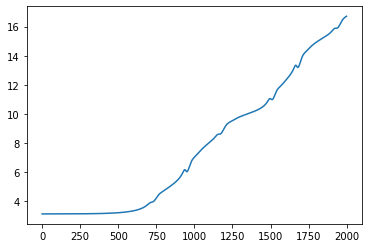

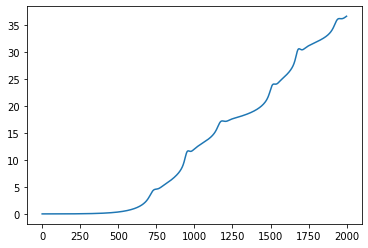

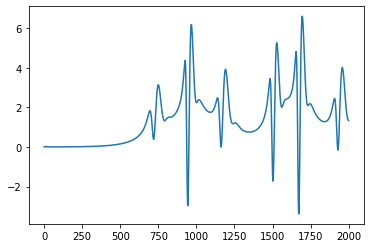

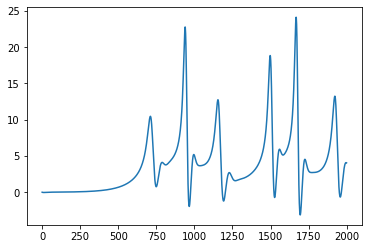

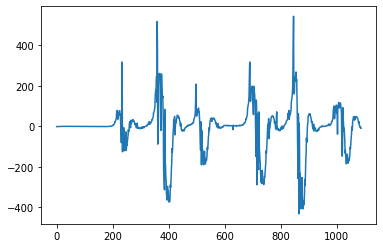

In [71]:
u_hist = []
k = np.array([300, -115, 64,10])
def control(q):
    goal = np.copy(q)
    goal[0] -= pi
    #goal[0] = 0
    #goal[1] = 0
    #return 0
    u_hist.append(k.dot(goal))
    return k.dot(goal)
    

model = PPOModelActHold(
    policy = MLP(6,1,2,24,nn.Tanh),
    value_fn = MLP(6,1,2,24,nn.Tanh),
    hold_count = 200,
    action_var = 5
)

tmax = 10
t = np.arange(0,tmax,.005)
s0 = np.array([pi,.01,0,0])
u_hist = []

sol = solve_ivp(_dsdt, [0,tmax], s0, t_eval=t)
y = sol.y.T
    
plt.plot(y[:,0])

plt.figure()
plt.plot(y[:,1])

plt.figure()
plt.plot(y[:,2])

plt.figure()
plt.plot(y[:,3])

plt.figure()
plt.plot(u_hist)
#plt.figure()
#plt.plot(cr)

#plt.figure()
#plt.plot(cl)

In [28]:

obs = env.reset()
env.state[0] = 2
env.state[1] = 1
env.state[2] = 0
env.state[3] = 0

for i in range(env.num_steps):
        #actions, _, _, _ = model.step(obs)
        #actions = np.zeros(1)
        #actions = env.action_space.sample()
        env.render()
        goal = np.copy(env.state)
        goal[0] -= pi
        target = [.5,.5,50,50]
    
        # have you ever seen code so beatiful
       # goal_thing = [True if np.abs(g) < t else False for g,t in zip(goal,target)]
       # if(all(goal_thing)):


        actions = k.dot(goal)
        action_debug[i,:] = -k*goal

        action_hist[i,:] = np.copy(actions)

        actions = np.clip(actions, -200,200)
        obs, reward, done, _ = env.step(actions)        

        #actions = np.clip(actions,-1,1)
       #     print("hello")
       # else:
        #actions,_,_,_ = model.step(obs)

            

        #import pdb; pdb.set_trace()
        #
        
        #actions = env.action_space.sample()

        
        
        state_hist[i,:] = np.copy(env.state)
        obs_hist[i,:] = np.copy(obs)
        
        reward_hist[i,:] = np.copy(reward)
        #time.sleep(.25)
        if done:
            break
     

KeyboardInterrupt: 

NameError: name 'i' is not defined

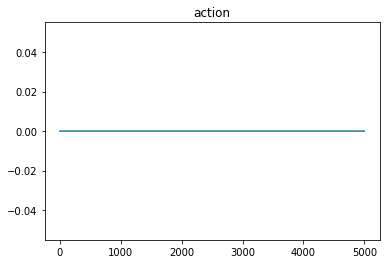

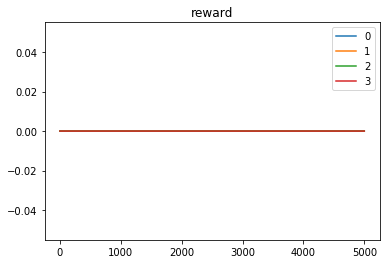

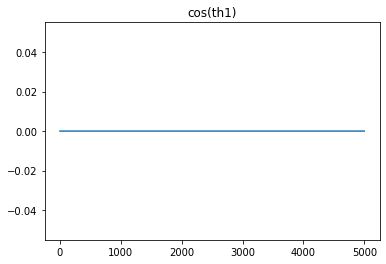

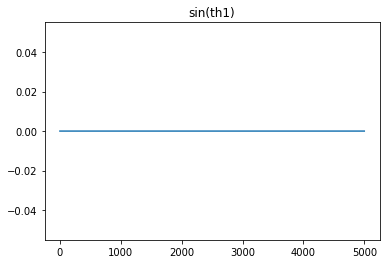

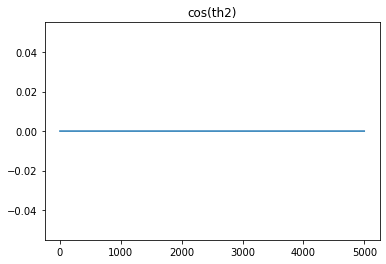

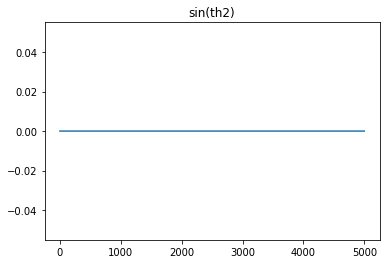

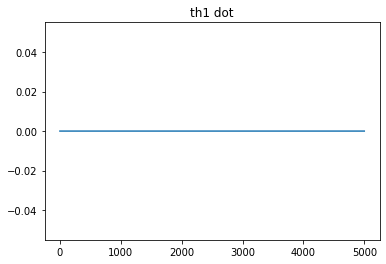

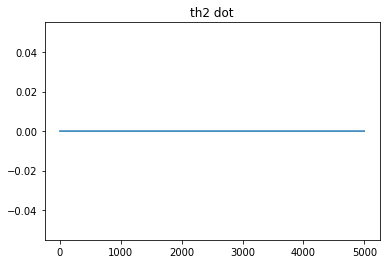

In [35]:
plt.plot(action_hist)
plt.title('action')

plt.figure()
plt.plot(action_debug)
plt.title('reward')
plt.legend(['0','1','2','3'])

plt.figure()
plt.plot(obs_hist[:,0])
plt.title("cos(th1)")

plt.figure()
plt.plot(obs_hist[:,1])
plt.title("sin(th1)")

plt.figure()
plt.plot(obs_hist[:,2])
plt.title("cos(th2)")

plt.figure()
plt.plot(obs_hist[:,3])
plt.title("sin(th2)")

plt.figure()
plt.plot(obs_hist[:,4])
plt.title("th1 dot")

plt.figure()
plt.plot(obs_hist[:,5])
plt.title("th2 dot")


print(i)
print(sum(reward_hist))